# ECE 4424 Final Project, Part 1 - Convolutional Neural Network
## Trevor Lew - trevllew751

In [ ]:
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from PIL import Image, ImageChops
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Images as Grayscale

In [ ]:
# root_path = "../Data/images_original"
root_path = "/content/drive/MyDrive/Spring Semester 2021-2022/ECE 4424 - Machine Learning/Final Project/Data/images_original"

x_train = []
y_train = []
x_val = []
y_val = []

percentage = 80 # Percentage of the data to use as training

# Stores all the flattened grayscale images
genres = {"blues": [],
          "classical": [],
          "country": [],
          "disco": [],
          "hiphop": [],
          "jazz": [],
          "metal": [],
          "pop": [],
          "reggae": [],
          "rock": []
          }

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# Goes through all the images, reads them as grayscale, stores them in the genres data structure
for genre in genres:
    for i in range(0, 100):
        try:
            # print(f"{root_path}/{genre}/{genre}{str(i).zfill(5)}.png")
            im = Image.open(f"{root_path}/{genre}/{genre}{str(i).zfill(5)}.png")
            im = im.convert("RGB")
            im = trim(im)
            im = im.resize((100, 100))
            im = im.convert("L")
            im = np.asarray(im)
            genres[genre].append(im)
        except:
            pass

# Grabs 'percentage' number of items from each genre for the validation then uses the remaining percentage as validation
for i, genre in enumerate(genres.keys()):
    x_train.extend(genres[genre][:percentage])
    x_val.extend(genres[genre][percentage:])

    y_train.extend([i] * percentage)
    y_val.extend([i] * (len(genres[genre]) - percentage))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

800
800
199
199


## Building the Model from Class

In [ ]:
def ClassModel():
    model = Sequential()

    # 1st convolution stack
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(100, 100, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout to mitigate overfitting
    model.add(Dropout(0.25))

    # 2nd convolution stack
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout to mitigate overfitting
    model.add(Dropout(0.25))

    # Flatten for fully connected layer
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(1000))
    model.add(Activation('relu'))

    # Dropout to mitigate overfitting
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(10))
    model.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    print(model.summary())

    return model

## Class Model Test Code

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 100, 100, 32)      320       
                                                                 
 activation_35 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 activation_36 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 50, 50, 32)        0         
                                                      

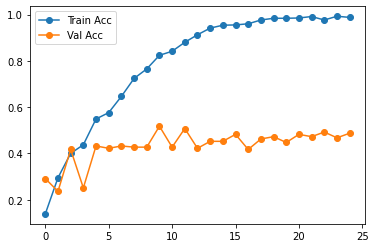

In [ ]:
model = ClassModel()
save_best_model = ModelCheckpoint('/tmp/checkpoint', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

result = model.fit(x_train, y_train,
                   batch_size=32,
                   epochs=25,
                   validation_data=(x_val, y_val),
                   shuffle=True,
                   callbacks=save_best_model)

plt.plot(result.history['accuracy'], 'o-', label="Train Acc")
plt.plot(result.history['val_accuracy'], 'o-', label="Val Acc")
plt.legend(loc="upper left")
plt.show()

## Building the LeNet-5 Architecture

In [ ]:
def LeNet5():
    model = Sequential()

    # 1st convolution 
    model.add(Conv2D(32, (5, 5), padding='same',input_shape=(100, 100, 1)))
    model.add(Activation('relu'))

    model.add(AveragePooling2D(pool_size=(2, 2)))

    # 2nd convolution
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))

    # Flatten for fully connected layer
    model.add(Flatten())

    # 1st fully connected layer
    model.add(Dense(1000))
    model.add(Activation('relu'))

    # 2nd fully connected layer
    model.add(Dense(400))
    model.add(Activation('relu'))

    # Output layer
    model.add(Dense(10))
    model.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    print(model.summary())

    return model

## LeNet-5 Test Code

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 100, 100, 32)      832       
                                                                 
 activation_41 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_26 (Conv2D)          (None, 50, 50, 64)        51264     
                                                                 
 activation_42 (Activation)  (None, 50, 50, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 160000)            0         
                                                      

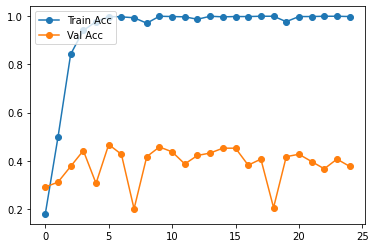

In [ ]:
model = LeNet5()
save_best_model = ModelCheckpoint('/tmp/checkpoint', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

result = model.fit(x_train, y_train,
                   batch_size=32,
                   epochs=25,
                   validation_data=(x_val, y_val),
                   shuffle=True,
                   callbacks=save_best_model)

plt.plot(result.history['accuracy'], 'o-', label="Train Acc")
plt.plot(result.history['val_accuracy'], 'o-', label="Val Acc")
plt.legend(loc="upper left")
plt.show()

## Building the AlexNet Architecture

In [ ]:
def AlexNet():
    model = Sequential()

    #1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(100,100,1), kernel_size=(11,11), strides=(4,4), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(32,32,3,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    #2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #Add Dropout
    model.add(Dropout(0.4))

    #3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #Add Dropout
    model.add(Dropout(0.4))

    #Output Layer
    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    print(model.summary())
    
    return model

## AlexNet Test Code

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 25, 25, 96)        11712     
                                                                 
 batch_normalization_18 (Bat  (None, 25, 25, 96)       384       
 chNormalization)                                                
                                                                 
 activation_46 (Activation)  (None, 25, 25, 96)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 256)       614656    
                                                                 
 batch_normalization_19 (Bat  (None, 13, 13, 256)     

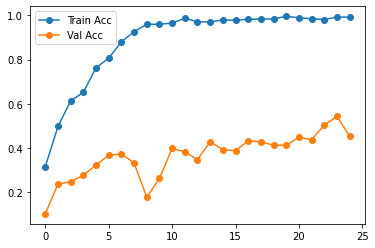

In [ ]:
model = AlexNet()
save_best_model = ModelCheckpoint('/tmp/checkpoint', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

result = model.fit(x_train, y_train,
                   batch_size=32,
                   epochs=25,
                   validation_data=(x_val, y_val),
                   shuffle=True,
                   callbacks=save_best_model)

plt.plot(result.history['accuracy'], 'o-', label="Train Acc")
plt.plot(result.history['val_accuracy'], 'o-', label="Val Acc")
plt.legend(loc="upper left")
plt.show()